In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import Normalizer

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Convolution1D, MaxPooling1D
from keras import callbacks
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import h5py
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [5]:
train1=pd.read_csv('Datas/ptbdb_abnormal.csv',header=None)
train2=pd.read_csv('Datas/ptbdb_normal.csv',header=None)
train1.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
train_normal=train1.iloc[:,0:187]
label_normal=train1.iloc[:,187]
train_abnormal=train2.iloc[:,0:187]
label_abnormal=train2.iloc[:,187]

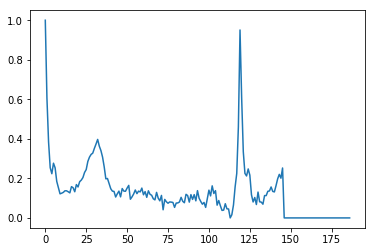

In [8]:
plt.plot(train1.iloc[1,0:187])
plt.show()

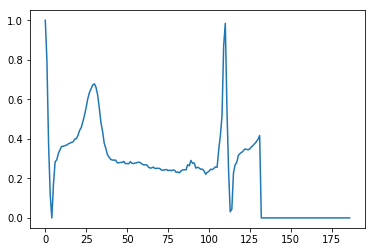

In [9]:
plt.plot(train2.iloc[1,0:187])
plt.show()

In [10]:
scaler1= Normalizer().fit(train_normal)
train_normal = scaler1.transform(train_normal)

scaler2= Normalizer().fit(train_abnormal)
train_abnormal = scaler2.transform(train_abnormal)

In [11]:
x1_train,x1_test,y1_train,y1_test=train_test_split(train_normal,label_normal,test_size=0.2,random_state=42)
x2_train,x2_test,y2_train,y2_test=train_test_split(train_abnormal,label_abnormal,test_size=0.2,random_state=42)


x_train=np.vstack((x1_train,x2_train))
x_test=np.vstack((x1_test,x2_test))
y_train=np.hstack((y1_train,y2_train))
y_test=np.hstack((y1_test,y2_test))

In [12]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(11640, 187)
(11640,)
(2912, 187)
(2912,)


In [13]:
x_train=np.array(x_train)
x_test=np.array(x_test)

x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
x_train.shape

(11640, 187, 1)

In [14]:
y_expected=y_test

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train.shape

(11640, 2)

In [15]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(11640, 187, 1)
(11640, 2)
(2912, 187, 1)
(2912, 2)


### Now loading the model learned for a differenet disesase arythmia, we are using this model for testing myocardinal, and checking whether model which learned features for one disease can predict other disease



In [14]:
from keras.models import load_model
model=load_model('results/checkpoint-10.hdf5')

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 186, 64)           256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 93, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5952)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               761984    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 762,885
Trainable params: 762,885
Non-trainable params: 0
_________________________________________________________________


### Freeing the weights of the first few layesr

#### here only last 3 layers will be trainable and rest all will be freezed(back propagation will not happen here, and only feed forward will happen here)


### when we freeze a particular layer, the weights will not be learned


####  model saves only learned things(weights) , not the computed layers(weights)


In [16]:
for layer in model.layers[:-3]:
    layer.trainable=False

In [17]:
for layer in model.layers:
    print(layer,layer.trainable)

<keras.layers.convolutional.Conv1D object at 0x00000279A272D978> False
<keras.layers.pooling.MaxPooling1D object at 0x00000279B09FCF28> False
<keras.layers.core.Flatten object at 0x00000279B09FCE80> False
<keras.layers.core.Dense object at 0x00000279B0A0EA20> True
<keras.layers.core.Dropout object at 0x00000279B0A2CC88> True
<keras.layers.core.Dense object at 0x00000279B0A2CB70> True


In [18]:
model2=Sequential()
model2.add(model)
model2.add(Dense(2,activation='sigmoid'))
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 5)                 762885    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 12        
Total params: 762,897
Trainable params: 762,641
Non-trainable params: 256
_________________________________________________________________


In [19]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
checkpointer = callbacks.ModelCheckpoint(filepath='results/checkpoint_myocardial-{epoch:02d}.hdf5', verbose=1, save_best_only=True, monitor='loss')
csv_logger = CSVLogger('results/cnntrainanalysis1_myocardial.csv', separator=',', append=False)


model2.fit(x_train,y_train, nb_epoch=10, callbacks=[checkpointer,csv_logger])
model2.save('results/model1_myocardial.hdf5')

Epoch 1/10
   96/11640 [..............................] - ETA: 13s - loss: 0.4983 - acc: 0.8333

C:\Users\Vyshnav\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


11640/11640 [==============================] - 13s 1ms/step - loss: 0.4606 - acc: 0.8707

Epoch 00001: loss improved from inf to 0.46064, saving model to results/checkpoint_myocardial-01.hdf5
Epoch 2/10
11640/11640 [==============================] - 13s 1ms/step - loss: 0.3673 - acc: 0.9072

Epoch 00002: loss improved from 0.46064 to 0.36734, saving model to results/checkpoint_myocardial-02.hdf5
Epoch 3/10
11640/11640 [==============================] - 13s 1ms/step - loss: 0.2957 - acc: 0.9195

Epoch 00003: loss improved from 0.36734 to 0.29571, saving model to results/checkpoint_myocardial-03.hdf5
Epoch 4/10
11640/11640 [==============================] - 13s 1ms/step - loss: 0.2453 - acc: 0.9310

Epoch 00004: loss improved from 0.29571 to 0.24532, saving model to results/checkpoint_myocardial-04.hdf5
Epoch 5/10
11640/11640 [==============================] - 13s 1ms/step - loss: 0.2101 - acc: 0.9419

Epoch 00005: loss improved from 0.24532 to 0.21010, saving model to results/checkpoint

In [20]:
#model2.load_weights('results/checkpoint_myocardial-01.hdf5')

In [22]:
y_pred = model2.predict_classes(x_test)

np.savetxt('results/expected.txt',y_expected, fmt='%01d')
np.savetxt('results/predicted.txt', y_pred, fmt='%01d')

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
loss, accuracy= model2.evaluate(x_test,y_test)

print('\nLoss: %.2f, Accuracy: %.2f%%' %(loss,accuracy*100) )

2912/2912 [==============================] - 1s 252us/step

Loss: 0.13, Accuracy: 96.33%


In [24]:
#from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score,confusion_matrix
import sklearn.metrics 

Acuuracy=sklearn.metrics.accuracy_score(y_expected,y_pred)
precision=sklearn.metrics.precision_score(y_expected,y_pred, average=None)
recall=sklearn.metrics.recall_score(y_expected,y_pred, average=None)
f1=sklearn.metrics.f1_score(y_expected,y_pred, average=None)


print('Acuuracy=',accuracy)
print('precision=',precision)
print('Recall=',recall)
print('f1_score=',f1)


Acuuracy= 0.9632554945054945
precision= [0.93234932 0.9752263 ]
Recall= [0.93580247 0.97383444]
f1_score= [0.9340727  0.97452987]


In [111]:
import sklearn.metrics
A=precision_score(y_expected,y_pred, average=None)
A

array([0.77, 0.79])

Confusion matrix, without normalization
[[ 758   52]
 [  55 2047]]
onfusion matrix
[[0.94 0.06]
 [0.03 0.97]]


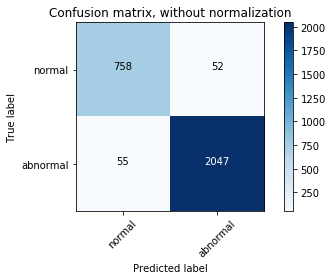

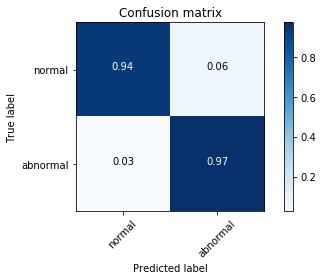

In [27]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
class_names=['normal','abnormal']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("onfusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_expected, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Confusion matrix')

plt.show()  

In [28]:
from sklearn.metrics import classification_report
sklearn.metrics.classification_report(y_expected, y_pred)
target_names = ['normal', 'abnormal']
print(classification_report(y_expected, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      normal       0.93      0.94      0.93       810
    abnormal       0.98      0.97      0.97      2102

   micro avg       0.96      0.96      0.96      2912
   macro avg       0.95      0.95      0.95      2912
weighted avg       0.96      0.96      0.96      2912



In [31]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_expected,y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)


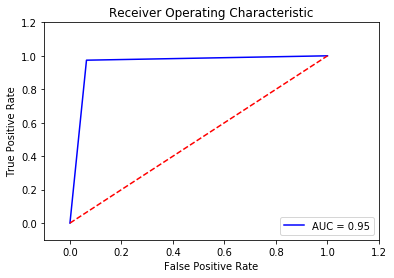

In [30]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()